## Include libraries, Set GPU 1 visible

In [1]:
# Header Files
import io
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import random
import warnings

import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

#from tqdm import tqdm 

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
#from keras.models import model_from_json


## Set options for GPU use

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.35)
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

## Set variables

In [3]:
# Path Variables
INPUT_H5 = "./trainX.h5"
MASKS_H5 = "./trainY.h5"
MODEL_H5 = "./resnet_adam_15fine_bn.h5"

# Size Variables

IMG_SIZE = (256,256)
BATCH_SIZE = 32
EPOCHS = 15
SEED = 303

## Input from H5

In [4]:
class DataLoad(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, input_img_paths, target_img_paths):
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // BATCH_SIZE

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * BATCH_SIZE
        batch_input_img_paths = self.input_img_paths[i : i + BATCH_SIZE]
        batch_target_img_paths = self.target_img_paths[i : i + BATCH_SIZE]
        x= np.zeros((BATCH_SIZE, 256,256,3), dtype=np.float32)
        for j, path in enumerate(batch_input_img_paths):
            h5 = h5py.File(INPUT_H5, 'r')
            data=h5.get(path)
            data=np.array(data)
            img = Image.open(io.BytesIO(data))
            img=np.array(img)
            
            assert img.shape == (256, 256, 3)
            x[j] = img
        
        y=np.zeros((BATCH_SIZE, 256, 256, 1), dtype=np.uint8)
        for j, path in enumerate(batch_target_img_paths):
            h51=h5py.File(MASKS_H5,'r')
            data=h51.get(path)
            data=np.array(data)
            mask=Image.open(io.BytesIO(data)).convert('L')
            mask=np.array(mask)
            mask=np.expand_dims(mask, axis=-1)
            
            assert mask.shape == (256, 256, 1)
            y[j]=mask
            
        return x, y
    


In [5]:
hf1 = h5py.File(INPUT_H5, 'r')
hf2 = h5py.File(MASKS_H5,'r')

input_image=[]
input_mask=[]

input_image = list(hf1.keys())
input_image = sorted(input_image)
#print(input_image)

input_mask = list(hf2.keys())
input_mask  = sorted(input_mask)
#print(input_mask)

print(len(input_image))
print(len(input_mask))

hf1.close()
hf2.close()


43292
43292


In [6]:
VAL_SAMPLES = 8658
random.Random(SEED).shuffle(input_image)
random.Random(SEED).shuffle(input_mask)

train_input_img_paths  =  input_image[:-VAL_SAMPLES]
train_target_img_paths =  input_mask[:-VAL_SAMPLES]
val_input_img_paths    =  input_image[-VAL_SAMPLES:]
val_target_img_paths   =  input_mask[-VAL_SAMPLES:]

train_input_img_paths=sorted(train_input_img_paths)
train_target_img_paths=sorted(train_target_img_paths)
val_input_img_paths=sorted(val_input_img_paths)
val_target_img_paths=sorted(val_target_img_paths)

## U-Net helper functions

In [7]:
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

NUM_CLASSES = 4

#BUILD THE U-NET MODEL
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y



## Vanilla (Normal) U-Net

output = 256 x 256

In [ ]:
######################### BASELINE VANILLA UNET #########################################

def uNet(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, nclasses=NUM_CLASSES, filters=16):
    # Contraction Path
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
    
    # Expansion Path
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)

    # output
    output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    
    return model



## U-Net with Resnet101 encoder

output = 256 x 256

In [ ]:
###################### UNET WITH RESNET ENCODER #######################################

resnet = tf.keras.applications.ResNet101(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3),
        pooling=max
    )


In [ ]:
# FREEZE layers except batch_norm
resnet.trainable = False

def uNetResnet(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, nclasses=NUM_CLASSES, filters=64):
    input_layer = resnet.input
    
    # Contraction path
    conv1 = resnet.get_layer('conv1_relu').output # 64 filters
    conv2 = resnet.get_layer('conv2_block3_out').output # 256
    conv3 = resnet.get_layer('conv3_block4_out').output # 512
    conv4 = resnet.get_layer('conv4_block23_out').output # 1024
    conv5 = resnet.get_layer('conv5_block3_out').output # 2048
    conv5 = Dropout(0.5)(conv5)
    
    # Expansion Path
    deconv4 = deconv_block(conv5, residual=conv4, nfilters=filters*16)
    deconv4 = Dropout(0.3)(deconv4)
    deconv3 = deconv_block(deconv4, residual=conv3, nfilters=filters*8)
    deconv3 = Dropout(0.5)(deconv3)
    deconv2 = deconv_block(deconv3, residual=conv2, nfilters=filters*4)
    deconv1 = deconv_block(deconv2, residual=conv1, nfilters=filters)
    
    # Output
    output_layer = Conv2DTranspose(filters//2, kernel_size=(3, 3), strides=(2, 2), padding='same')(deconv1)
    output_layer = conv_block(output_layer, nfilters=filters//4)
    output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1, 1))(output_layer)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model



## Data generators

In [8]:
train_gen = DataLoad(train_input_img_paths, train_target_img_paths)
val_gen = DataLoad(val_input_img_paths, val_target_img_paths)

print(len(train_gen))
print(len(val_gen))

1082
270


## Callbacks and metrics

In [9]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=6, monitor='loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs', write_graph=True),
        tf.keras.callbacks.ModelCheckpoint(MODEL_H5, monitor='loss', verbose=1, save_best_only=True)
]


In [ ]:
def ret_iou(y_true, y_pred, smooth=1):
    temp_true = y_true.flatten()
    temp_pred = np.argmax(y_pred, axis=3).flatten()
    
    temp = (temp_true == temp_pred).astype(bool)
    union = temp.logical_not().astype(int)
    union = 1 + union 
    intersection = temp.astype(int)
    
    union = np.sum(union)
    intersection = np.sum(intersection)
    
    return (intersection+smooth)/(union+smooth)

## Initialize model or Fine tune pretrained model

In [10]:
#model = uNet()
#model = uNetResnet()
model = load_model("resnet_adam_50epochs.h5")

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']  

# Compile if any of above fresh models are used or if you are fine tuning
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)


# Uncomment lines below when fine tuning
model.trainable = True
for layer in model.layers:
    if layer.name.endswith('bn'):
        layer.trainable = False

## Train Model

In [ ]:
results = model.fit(train_gen,epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=1, validation_data=val_gen,callbacks=callbacks)
print(results)

model.save("model_weights_all_epochs.h5")

print("Model Saved")

Epoch 1/15
 225/1082 [=====>........................] - ETA: 4:56 - loss: 0.0430 - accuracy: 0.6124

In [ ]:
model

In [12]:
print(results.history)

{'loss': [0.04274902865290642, 0.04010121151804924, 0.03918413445353508, 0.038412973284721375, 0.03790188953280449, 0.037439145147800446, 0.03695005178451538, 0.036587510257959366, 0.036264967173337936, 0.035863231867551804, 0.03559063747525215, 0.035252660512924194, 0.034969575703144073, 0.034696850925683975, 0.034450992941856384], 'accuracy': [0.5975080132484436, 0.5976006984710693, 0.5975691080093384, 0.5976065397262573, 0.5976032018661499, 0.5976159572601318, 0.5976588129997253, 0.5976415276527405, 0.5976558923721313, 0.5976520776748657, 0.5976757407188416, 0.5976719856262207, 0.5976893901824951, 0.5977116823196411, 0.5976933240890503], 'val_loss': [0.1899702250957489, 0.19290366768836975, 0.1910959929227829, 0.19183053076267242, 0.1968296617269516, 0.2001451998949051, 0.19430138170719147, 0.2087075114250183, 0.2100648432970047, 0.22749783098697662, 0.21325570344924927, 0.20816552639007568, 0.2055782526731491, 0.1979503631591797, 0.21168379485607147], 'val_accuracy': [0.62719351053

## Testing model

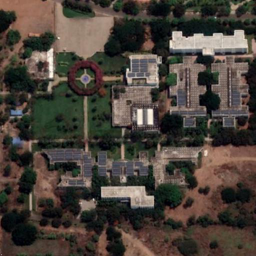

(256, 256, 4)


In [13]:
#model = load_model('resnet_adam_15fine.h5')
X_pred = Image.open("ssn_sample.jpg", 'r').resize((256, 256))
display(X_pred)

X_pred = np.array(X_pred)
X_pred = np.array([X_pred])

Y_pred = model.predict(X_pred)

print(Y_pred[0].shape)

In [14]:
test = np.argmax(Y_pred[0], axis=2)
test = np.expand_dims(test, axis=-1)
np.unique(test)

array([0, 1, 2])

In [15]:
mask = np.zeros((256, 256, 3), dtype=np.uint8)
for i in range(256):
    for j in range(256):
        if test[i][j] == 0:
            mask[i][j] = [255, 255, 255]
        elif test[i][j] == 1: # BUILDING
            mask[i][j] = [255, 0, 0]
        elif test[i][j] == 2: # Green
            mask[i][j] = [0, 255, 0]
        elif test[i][j] == 3: # Water
            mask[i][j] = [0, 0, 255]

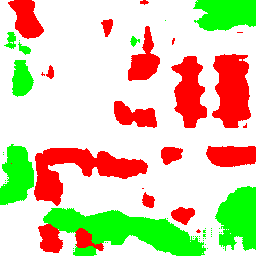

In [16]:
mask = Image.fromarray(mask)
display(mask)

In [ ]:
h51=h5py.File(MASKS_H5,'r')
data=h51.get(list(h51.keys())[0])
data=np.array(data)
mask=Image.open(io.BytesIO(data)).convert('L')
mask=np.array(mask)
mask=np.expand_dims(mask, axis=-1)
print(mask)